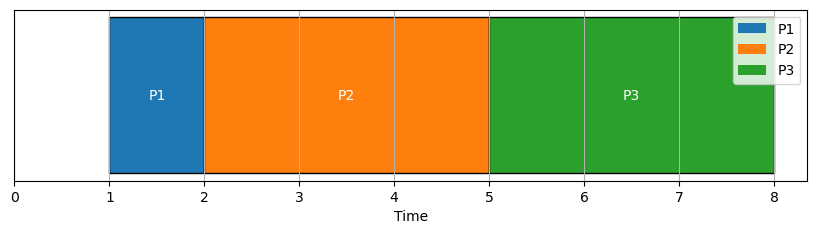

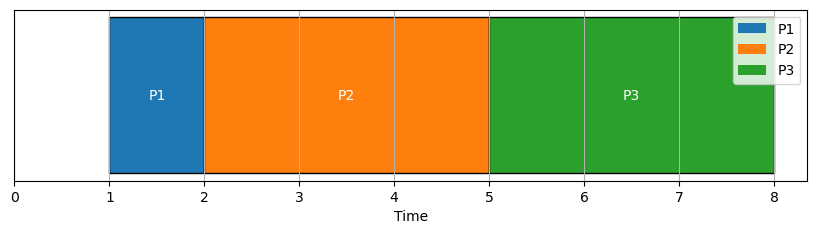

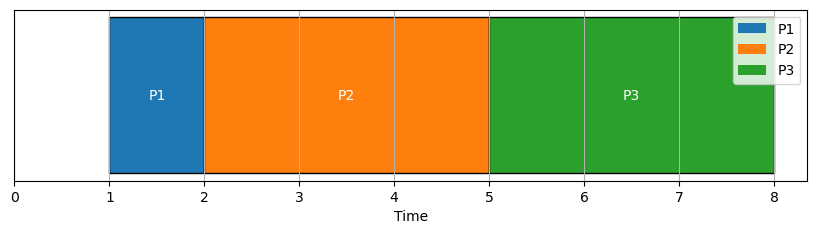

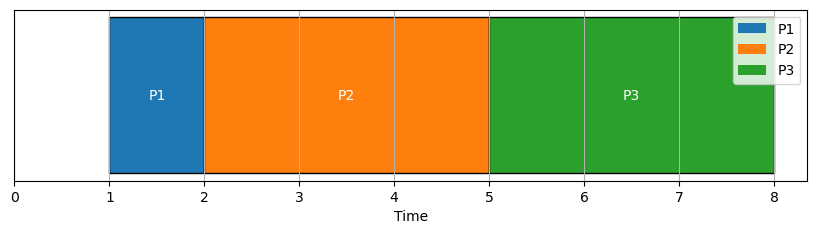

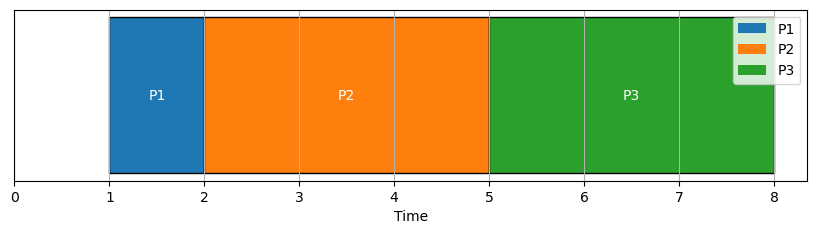

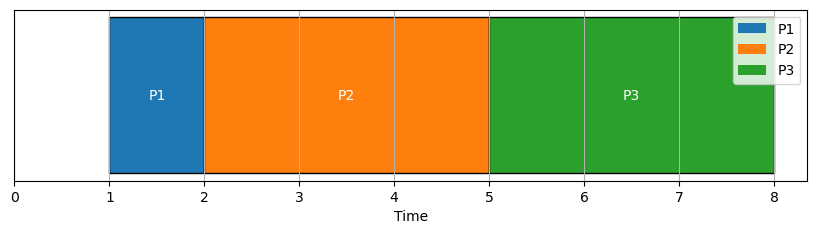

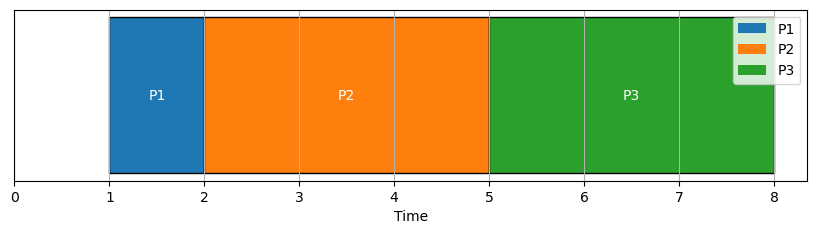

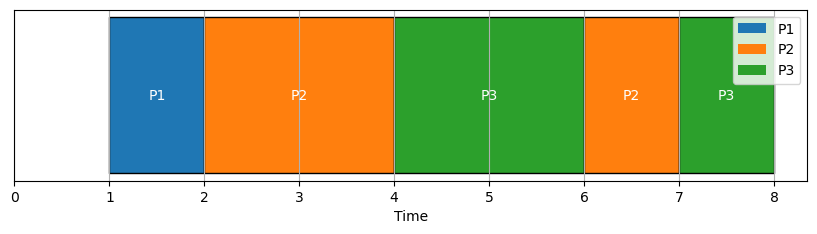

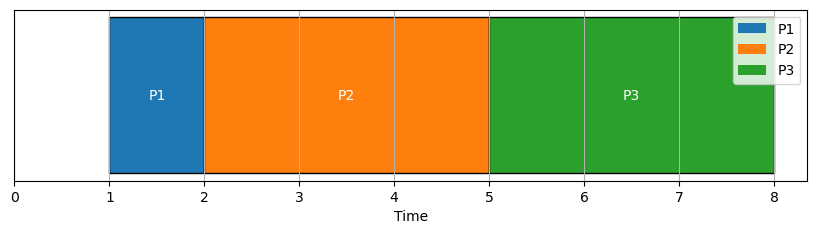

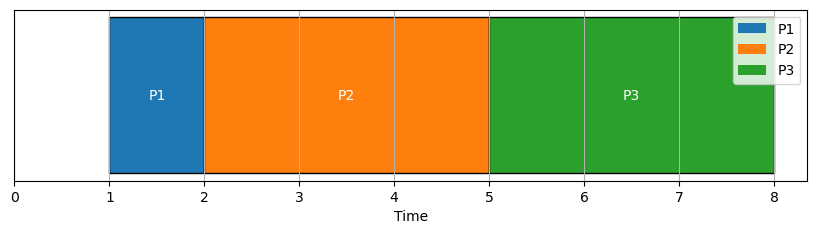

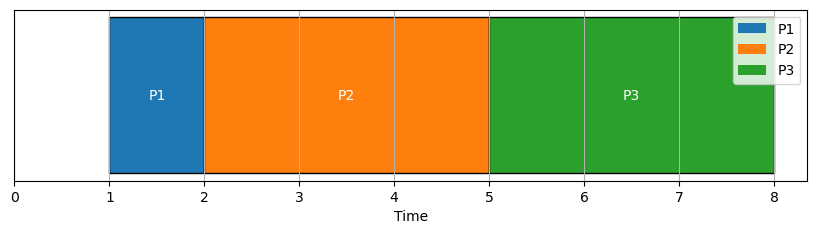

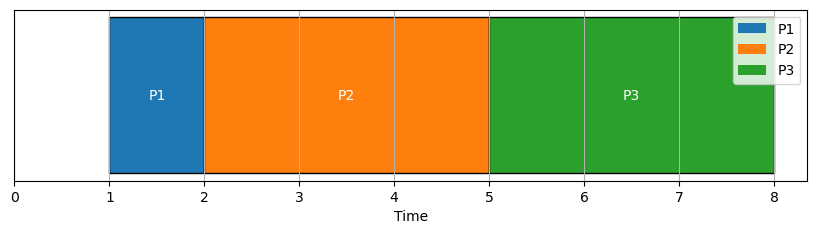

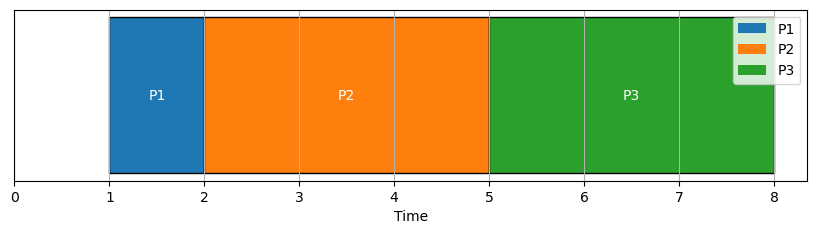

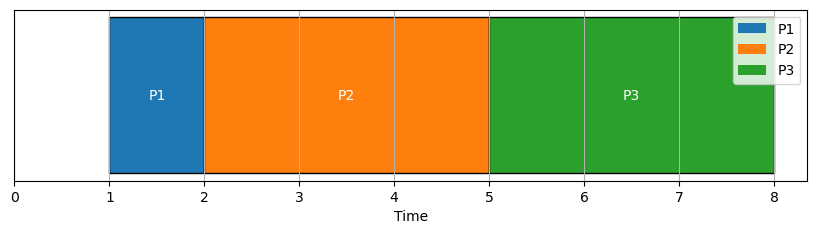

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox
from collections import deque
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class CPUSchedulingSimulator:
    def __init__(self, root):
        self.root = root
        self.root.title("CPU Scheduling Simulator")
        self.root.geometry("1000x700")
        
        self.processes = []
        self.current_algorithm = "FCFS"
        self.gantt_chart_data = []
        
        self.create_widgets()
        self.create_sample_data()
        
    def create_widgets(self):
        # Main frame
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Left panel - Process input
        left_frame = ttk.LabelFrame(main_frame, text="Process List", padding="10")
        left_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        
        # Process input fields
        ttk.Label(left_frame, text="Process ID").grid(row=0, column=0, padx=5, pady=2)
        ttk.Label(left_frame, text="Arrival Time").grid(row=0, column=1, padx=5, pady=2)
        ttk.Label(left_frame, text="Burst Time").grid(row=0, column=2, padx=5, pady=2)
        ttk.Label(left_frame, text="Priority").grid(row=0, column=3, padx=5, pady=2)
        
        self.pid_entry = ttk.Entry(left_frame, width=10)
        self.arrival_entry = ttk.Entry(left_frame, width=10)
        self.burst_entry = ttk.Entry(left_frame, width=10)
        self.priority_entry = ttk.Entry(left_frame, width=10)
        
        self.pid_entry.grid(row=1, column=0, padx=5, pady=2)
        self.arrival_entry.grid(row=1, column=1, padx=5, pady=2)
        self.burst_entry.grid(row=1, column=2, padx=5, pady=2)
        self.priority_entry.grid(row=1, column=3, padx=5, pady=2)
        
        # Add process button
        add_btn = ttk.Button(left_frame, text="+ Add Process", command=self.add_process)
        add_btn.grid(row=1, column=4, padx=5, pady=2)
        
        # Process table
        self.process_table = ttk.Treeview(left_frame, columns=("pid", "arrival", "burst", "priority"), show="headings")
        self.process_table.heading("pid", text="Process ID")
        self.process_table.heading("arrival", text="Arrival Time")
        self.process_table.heading("burst", text="Burst Time")
        self.process_table.heading("priority", text="Priority")
        self.process_table.column("pid", width=80)
        self.process_table.column("arrival", width=80)
        self.process_table.column("burst", width=80)
        self.process_table.column("priority", width=80)
        self.process_table.grid(row=2, column=0, columnspan=5, pady=10, sticky="nsew")
        
        # Delete process button
        del_btn = ttk.Button(left_frame, text="Delete Selected", command=self.delete_process)
        del_btn.grid(row=3, column=0, columnspan=5, pady=5)
        
        # Algorithm selection
        algo_frame = ttk.LabelFrame(left_frame, text="Scheduling Algorithm", padding="10")
        algo_frame.grid(row=4, column=0, columnspan=5, sticky="ew")
        
        self.algo_var = tk.StringVar(value="FCFS")
        algorithms = [
            ("First-Come, First-Served (FCFS)", "FCFS"),
            ("Shortest Job First (SJF)", "SJF"),
            ("Shortest Remaining Time First (SRTF)", "SRTF"),
            ("Priority Scheduling", "Priority"),
            ("Round Robin (RR)", "RR")
        ]
        
        for i, (text, algo) in enumerate(algorithms):
            rb = ttk.Radiobutton(algo_frame, text=text, variable=self.algo_var, value=algo)
            rb.grid(row=i//2, column=i%2, sticky="w", padx=5, pady=2)
        
        # For Round Robin, add quantum input
        self.quantum_frame = ttk.Frame(algo_frame)
        self.quantum_frame.grid(row=2, column=1, sticky="w")
        ttk.Label(self.quantum_frame, text="Time Quantum:").pack(side=tk.LEFT)
        self.quantum_entry = ttk.Entry(self.quantum_frame, width=5)
        self.quantum_entry.pack(side=tk.LEFT, padx=5)
        self.quantum_entry.insert(0, "2")
        self.quantum_frame.grid_remove()  # Hide initially
        
        # Show quantum input only when RR is selected
        self.algo_var.trace_add("write", self.toggle_quantum_input)
        
        # Simulate button
        simulate_btn = ttk.Button(left_frame, text="Simulate", command=self.simulate)
        simulate_btn.grid(row=5, column=0, columnspan=5, pady=10)
        
        # Right panel - Results
        right_frame = ttk.Frame(main_frame, padding="10")
        right_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True)
        
        # Gantt chart
        gantt_frame = ttk.LabelFrame(right_frame, text="Gantt Chart", padding="10")
        gantt_frame.pack(fill=tk.BOTH, expand=True)
        
        self.gantt_canvas_frame = ttk.Frame(gantt_frame)
        self.gantt_canvas_frame.pack(fill=tk.BOTH, expand=True)
        
        # Results
        results_frame = ttk.LabelFrame(right_frame, text="Results", padding="10")
        results_frame.pack(fill=tk.X, pady=10)
        
        self.avg_tat_label = ttk.Label(results_frame, text="Average Turnaround Time: ")
        self.avg_tat_label.pack(anchor="w")
        
        self.avg_wt_label = ttk.Label(results_frame, text="Average Waiting Time: ")
        self.avg_wt_label.pack(anchor="w")
        
        # Detailed results table
        self.results_table = ttk.Treeview(
            right_frame, 
            columns=("pid", "arrival", "burst", "priority", "completion", "waiting", "turnaround"), 
            show="headings"
        )
        self.results_table.heading("pid", text="Process ID")
        self.results_table.heading("arrival", text="Arrival Time")
        self.results_table.heading("burst", text="Burst Time")
        self.results_table.heading("priority", text="Priority")
        self.results_table.heading("completion", text="Completion Time")
        self.results_table.heading("waiting", text="Waiting Time")
        self.results_table.heading("turnaround", text="Turnaround Time")
        
        for col in ("pid", "arrival", "burst", "priority", "completion", "waiting", "turnaround"):
            self.results_table.column(col, width=80, anchor="center")
        
        self.results_table.pack(fill=tk.BOTH, expand=True)
        
    def toggle_quantum_input(self, *args):
        if self.algo_var.get() == "RR":
            self.quantum_frame.grid()
        else:
            self.quantum_frame.grid_remove()
    
    def create_sample_data(self):
        sample_data = [
            (1, 1, 1, 0),
            (2, 2, 3, 0),
            (3, 3, 3, 0)
        ]
        
        for pid, arrival, burst, priority in sample_data:
            self.process_table.insert("", tk.END, values=(pid, arrival, burst, priority))
            self.processes.append({
                "pid": pid,
                "arrival": arrival,
                "burst": burst,
                "priority": priority,
                "remaining": burst
            })
    
    def add_process(self):
        try:
            pid = int(self.pid_entry.get())
            arrival = int(self.arrival_entry.get())
            burst = int(self.burst_entry.get())
            priority = int(self.priority_entry.get())
            
            if burst <= 0:
                messagebox.showerror("Error", "Burst time must be positive")
                return
                
            # Check if PID already exists
            for item in self.process_table.get_children():
                if self.process_table.item(item)["values"][0] == pid:
                    messagebox.showerror("Error", "Process ID must be unique")
                    return
            
            self.process_table.insert("", tk.END, values=(pid, arrival, burst, priority))
            self.processes.append({
                "pid": pid,
                "arrival": arrival,
                "burst": burst,
                "priority": priority,
                "remaining": burst
            })
            
            # Clear entries
            self.pid_entry.delete(0, tk.END)
            self.arrival_entry.delete(0, tk.END)
            self.burst_entry.delete(0, tk.END)
            self.priority_entry.delete(0, tk.END)
            
        except ValueError:
            messagebox.showerror("Error", "Please enter valid numbers for all fields")
    
    def delete_process(self):
        selected = self.process_table.selection()
        if not selected:
            return
            
        for item in selected:
            pid = self.process_table.item(item)["values"][0]
            self.process_table.delete(item)
            
            # Remove from processes list
            self.processes = [p for p in self.processes if p["pid"] != pid]
    
    def simulate(self):
        if not self.processes:
            messagebox.showerror("Error", "No processes to simulate")
            return
            
        # Clear previous results
        self.gantt_chart_data = []
        for item in self.results_table.get_children():
            self.results_table.delete(item)
        
        # Get algorithm and quantum if RR
        algorithm = self.algo_var.get()
        quantum = 2  # default
        if algorithm == "RR":
            try:
                quantum = int(self.quantum_entry.get())
                if quantum <= 0:
                    raise ValueError
            except ValueError:
                messagebox.showerror("Error", "Please enter a valid positive integer for quantum")
                return
        
        # Reset remaining time for all processes
        for process in self.processes:
            process["remaining"] = process["burst"]
            process["completion"] = 0
            process["waiting"] = 0
            process["turnaround"] = 0
        
        # Run the selected algorithm
        if algorithm == "FCFS":
            self.run_fcfs()
        elif algorithm == "SJF":
            self.run_sjf()
        elif algorithm == "SRTF":
            self.run_srtf()
        elif algorithm == "Priority":
            self.run_priority()
        elif algorithm == "RR":
            self.run_rr(quantum)
        
        # Calculate metrics and display results
        self.calculate_metrics()
        self.display_results()
        self.draw_gantt_chart()
    
    def run_fcfs(self):
        # Sort processes by arrival time
        ready_queue = sorted(self.processes, key=lambda x: x["arrival"])
        current_time = 0
        
        for process in ready_queue:
            if current_time < process["arrival"]:
                current_time = process["arrival"]
            
            # Record start and end times for Gantt chart
            start_time = current_time
            end_time = current_time + process["burst"]
            self.gantt_chart_data.append({
                "pid": process["pid"],
                "start": start_time,
                "end": end_time
            })
            
            # Update process completion time
            process["completion"] = end_time
            current_time = end_time
    
    def run_sjf(self):
        ready_queue = []
        current_time = 0
        completed = 0
        n = len(self.processes)
        
        while completed < n:
            # Add arrived processes to ready queue
            for p in self.processes:
                if p["arrival"] <= current_time and p["remaining"] > 0 and p not in ready_queue:
                    ready_queue.append(p)
            
            if not ready_queue:
                current_time += 1
                continue
                
            # Sort by remaining burst time
            ready_queue.sort(key=lambda x: x["remaining"])
            process = ready_queue[0]
            
            # Record start and end times for Gantt chart
            start_time = current_time
            end_time = current_time + process["remaining"]
            self.gantt_chart_data.append({
                "pid": process["pid"],
                "start": start_time,
                "end": end_time
            })
            
            # Update process completion time
            process["completion"] = end_time
            process["remaining"] = 0
            current_time = end_time
            completed += 1
            ready_queue.pop(0)
    
    def run_srtf(self):
        current_time = 0
        completed = 0
        n = len(self.processes)
        prev_process = None
        
        while completed < n:
            # Find process with shortest remaining time that has arrived
            min_remaining = float('inf')
            selected_process = None
            
            for p in self.processes:
                if p["arrival"] <= current_time and p["remaining"] > 0:
                    if p["remaining"] < min_remaining:
                        min_remaining = p["remaining"]
                        selected_process = p
            
            if not selected_process:
                current_time += 1
                continue
                
            # If process changed, record the previous process's execution
            if prev_process and prev_process["pid"] != selected_process["pid"]:
                self.gantt_chart_data[-1]["end"] = current_time
            
            # If no previous process or process changed, add new entry
            if not prev_process or prev_process["pid"] != selected_process["pid"]:
                self.gantt_chart_data.append({
                    "pid": selected_process["pid"],
                    "start": current_time,
                    "end": current_time + 1  # Will be updated next cycle
                })
            
            # Execute for 1 unit of time
            selected_process["remaining"] -= 1
            current_time += 1
            prev_process = selected_process
            
            # If process completed
            if selected_process["remaining"] == 0:
                selected_process["completion"] = current_time
                completed += 1
                # Update the end time in Gantt chart
                self.gantt_chart_data[-1]["end"] = current_time
                prev_process = None
    
    def run_priority(self):
        ready_queue = []
        current_time = 0
        completed = 0
        n = len(self.processes)
        
        while completed < n:
            # Add arrived processes to ready queue
            for p in self.processes:
                if p["arrival"] <= current_time and p["remaining"] > 0 and p not in ready_queue:
                    ready_queue.append(p)
            
            if not ready_queue:
                current_time += 1
                continue
                
            # Sort by priority (lower number = higher priority)
            ready_queue.sort(key=lambda x: x["priority"])
            process = ready_queue[0]
            
            # Record start and end times for Gantt chart
            start_time = current_time
            end_time = current_time + process["remaining"]
            self.gantt_chart_data.append({
                "pid": process["pid"],
                "start": start_time,
                "end": end_time
            })
            
            # Update process completion time
            process["completion"] = end_time
            process["remaining"] = 0
            current_time = end_time
            completed += 1
            ready_queue.pop(0)
    
    def run_rr(self, quantum):
        ready_queue = deque()
        current_time = 0
        completed = 0
        n = len(self.processes)
        time_slice = quantum
        
        # Sort processes by arrival time initially
        processes_sorted = sorted(self.processes, key=lambda x: x["arrival"])
        i = 0
        
        while completed < n:
            # Add arrived processes to ready queue
            while i < n and processes_sorted[i]["arrival"] <= current_time:
                ready_queue.append(processes_sorted[i])
                i += 1
            
            if not ready_queue:
                current_time += 1
                continue
                
            process = ready_queue.popleft()
            
            # Determine execution time (minimum of quantum or remaining time)
            exec_time = min(time_slice, process["remaining"])
            
            # Record start and end times for Gantt chart
            start_time = current_time
            end_time = current_time + exec_time
            self.gantt_chart_data.append({
                "pid": process["pid"],
                "start": start_time,
                "end": end_time
            })
            
            # Update process remaining time
            process["remaining"] -= exec_time
            current_time = end_time
            
            # If process completed
            if process["remaining"] == 0:
                process["completion"] = current_time
                completed += 1
            else:
                # Add arrived processes while this process was executing
                while i < n and processes_sorted[i]["arrival"] <= current_time:
                    ready_queue.append(processes_sorted[i])
                    i += 1
                # Add the current process back to queue
                ready_queue.append(process)
    
    def calculate_metrics(self):
        total_waiting = 0
        total_turnaround = 0
        
        for process in self.processes:
            process["turnaround"] = process["completion"] - process["arrival"]
            process["waiting"] = process["turnaround"] - process["burst"]
            total_waiting += process["waiting"]
            total_turnaround += process["turnaround"]
        
        self.avg_waiting = total_waiting / len(self.processes)
        self.avg_turnaround = total_turnaround / len(self.processes)
    
    def display_results(self):
        self.avg_tat_label.config(text=f"Average Turnaround Time: {self.avg_turnaround:.2f}")
        self.avg_wt_label.config(text=f"Average Waiting Time: {self.avg_waiting:.2f}")
        
        for process in sorted(self.processes, key=lambda x: x["pid"]):
            self.results_table.insert("", tk.END, values=(
                process["pid"],
                process["arrival"],
                process["burst"],
                process["priority"],
                process["completion"],
                process["waiting"],
                process["turnaround"]
            ))
    
    def draw_gantt_chart(self):
        # Clear previous chart
        for widget in self.gantt_canvas_frame.winfo_children():
            widget.destroy()
        
        if not self.gantt_chart_data:
            return
            
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 2))
        fig.subplots_adjust(bottom=0.3)
        
        # Get unique process IDs for coloring
        unique_pids = list(set([item["pid"] for item in self.gantt_chart_data]))
        colors = plt.cm.tab10.colors[:len(unique_pids)]
        pid_to_color = {pid: colors[i] for i, pid in enumerate(unique_pids)}
        
        # Draw bars
        for item in self.gantt_chart_data:
            duration = item["end"] - item["start"]
            ax.broken_barh([(item["start"], duration)], (0, 1), 
                          facecolors=pid_to_color[item["pid"]], 
                          edgecolor='black')
            # Add label in the middle of the bar
            ax.text(item["start"] + duration/2, 0.5, f"P{item['pid']}", 
                   ha='center', va='center', color='white')
        
        # Set axes and ticks
        ax.set_yticks([])
        ax.set_xlabel("Time")
        ax.set_xticks(range(int(self.gantt_chart_data[-1]["end"]) + 1))
        ax.grid(True, axis='x')
        
        # Create legend
        patches = [plt.Rectangle((0,0),1,1, fc=pid_to_color[pid]) for pid in unique_pids]
        ax.legend(patches, [f"P{pid}" for pid in unique_pids], loc='upper right')
        
        # Embed in Tkinter
        canvas = FigureCanvasTkAgg(fig, master=self.gantt_canvas_frame)
        canvas.draw()
        canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)

if __name__ == "__main__":
    root = tk.Tk()
    app = CPUSchedulingSimulator(root)
    root.mainloop()